# Linear Regression

In this lab we set up a basic linear regression and explore different loss functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import linear_model #New!

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
#matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300

#### We begin by generating some data.

In [21]:
np.random.seed(16) #set seed for reproducibility purposes
x = np.arange(100) 
yp = 3*x + 3 + 2*(np.random.poisson(3*x+3,100)-(3*x+3)) #generate some data with scatter following Poisson distribution 
                                                        #with exp value = y from linear model, centered around 0


## Step 1: sklearn's regression

Set up a linear regression model using *LinearRegression()*. Fit to the data, print the slope and intercept. (When only one predictor is present, you need to reshape it to column form.) Plot the data in a scatter plot, add the fit line and the "true" regression line y=3x+3.

Slope: 3.02
Intercept: -0.13


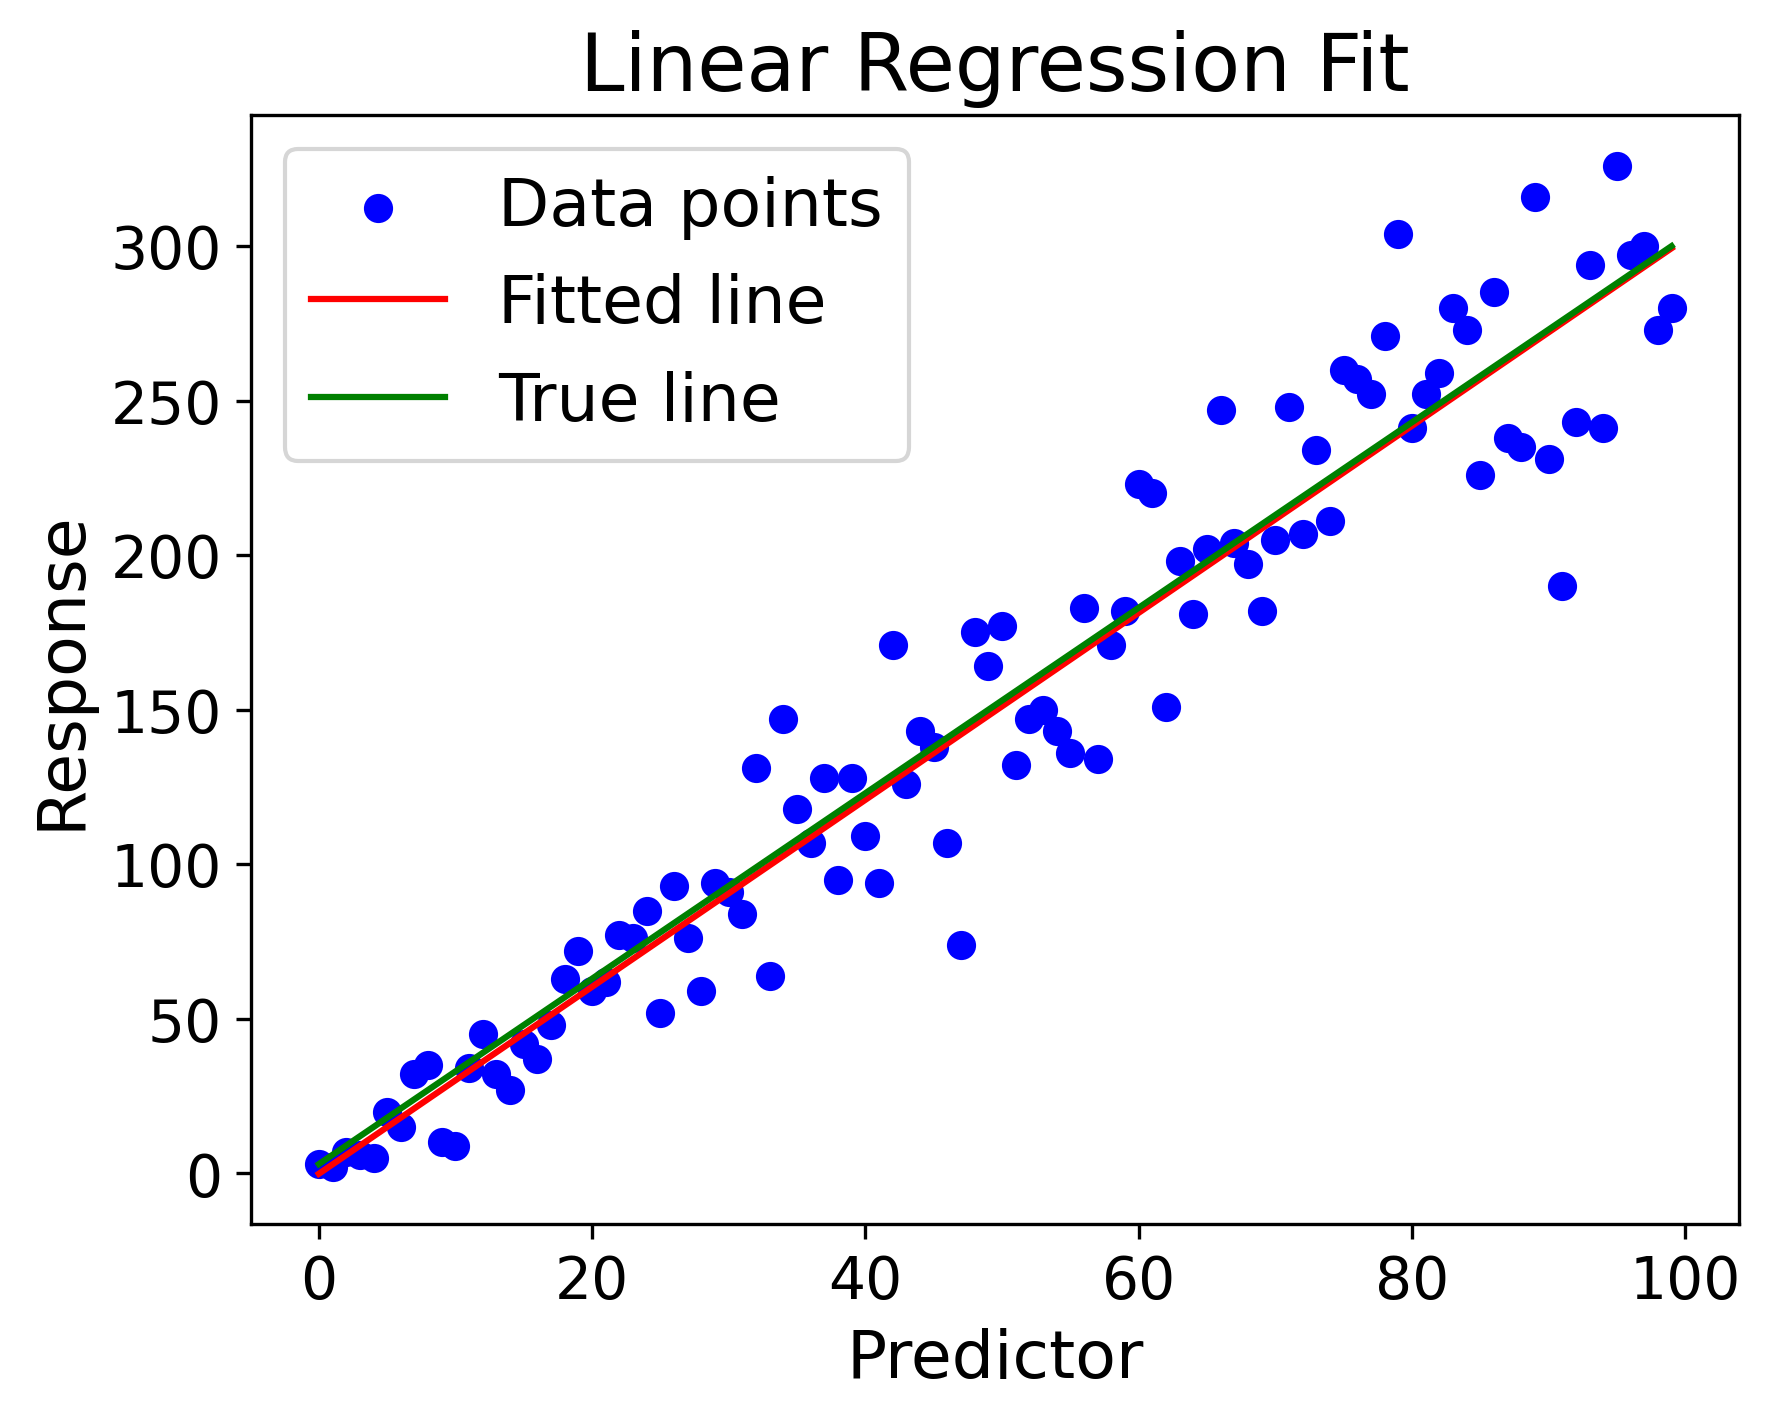

In [25]:

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

x_new  =  x.reshape(-1,1)
# Fit the model
lin_reg.fit(x_new, yp)

# Retrieve the intercept (b) and slope (m) of the line
intercept = lin_reg.intercept_
slope = lin_reg.coef_[0]

# Print the slope and intercept
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")

# Plot the data
plt.scatter(x_new, yp, color='blue', label='Data points')

# Plot the fitted line
x_fit = x_new
y_fit = lin_reg.predict(x_fit)
plt.plot(x_fit, y_fit, color='red', label='Fitted line')

# Plot the "true" line
y_true = 3 * x_fit + 3
plt.plot(x_fit, y_true, color='green', label='True line')

# Add labels and legend
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()

Now plot the residuals, i.e. the difference between true regression line and actual data. Are the residuals independent of x? What does this mean?

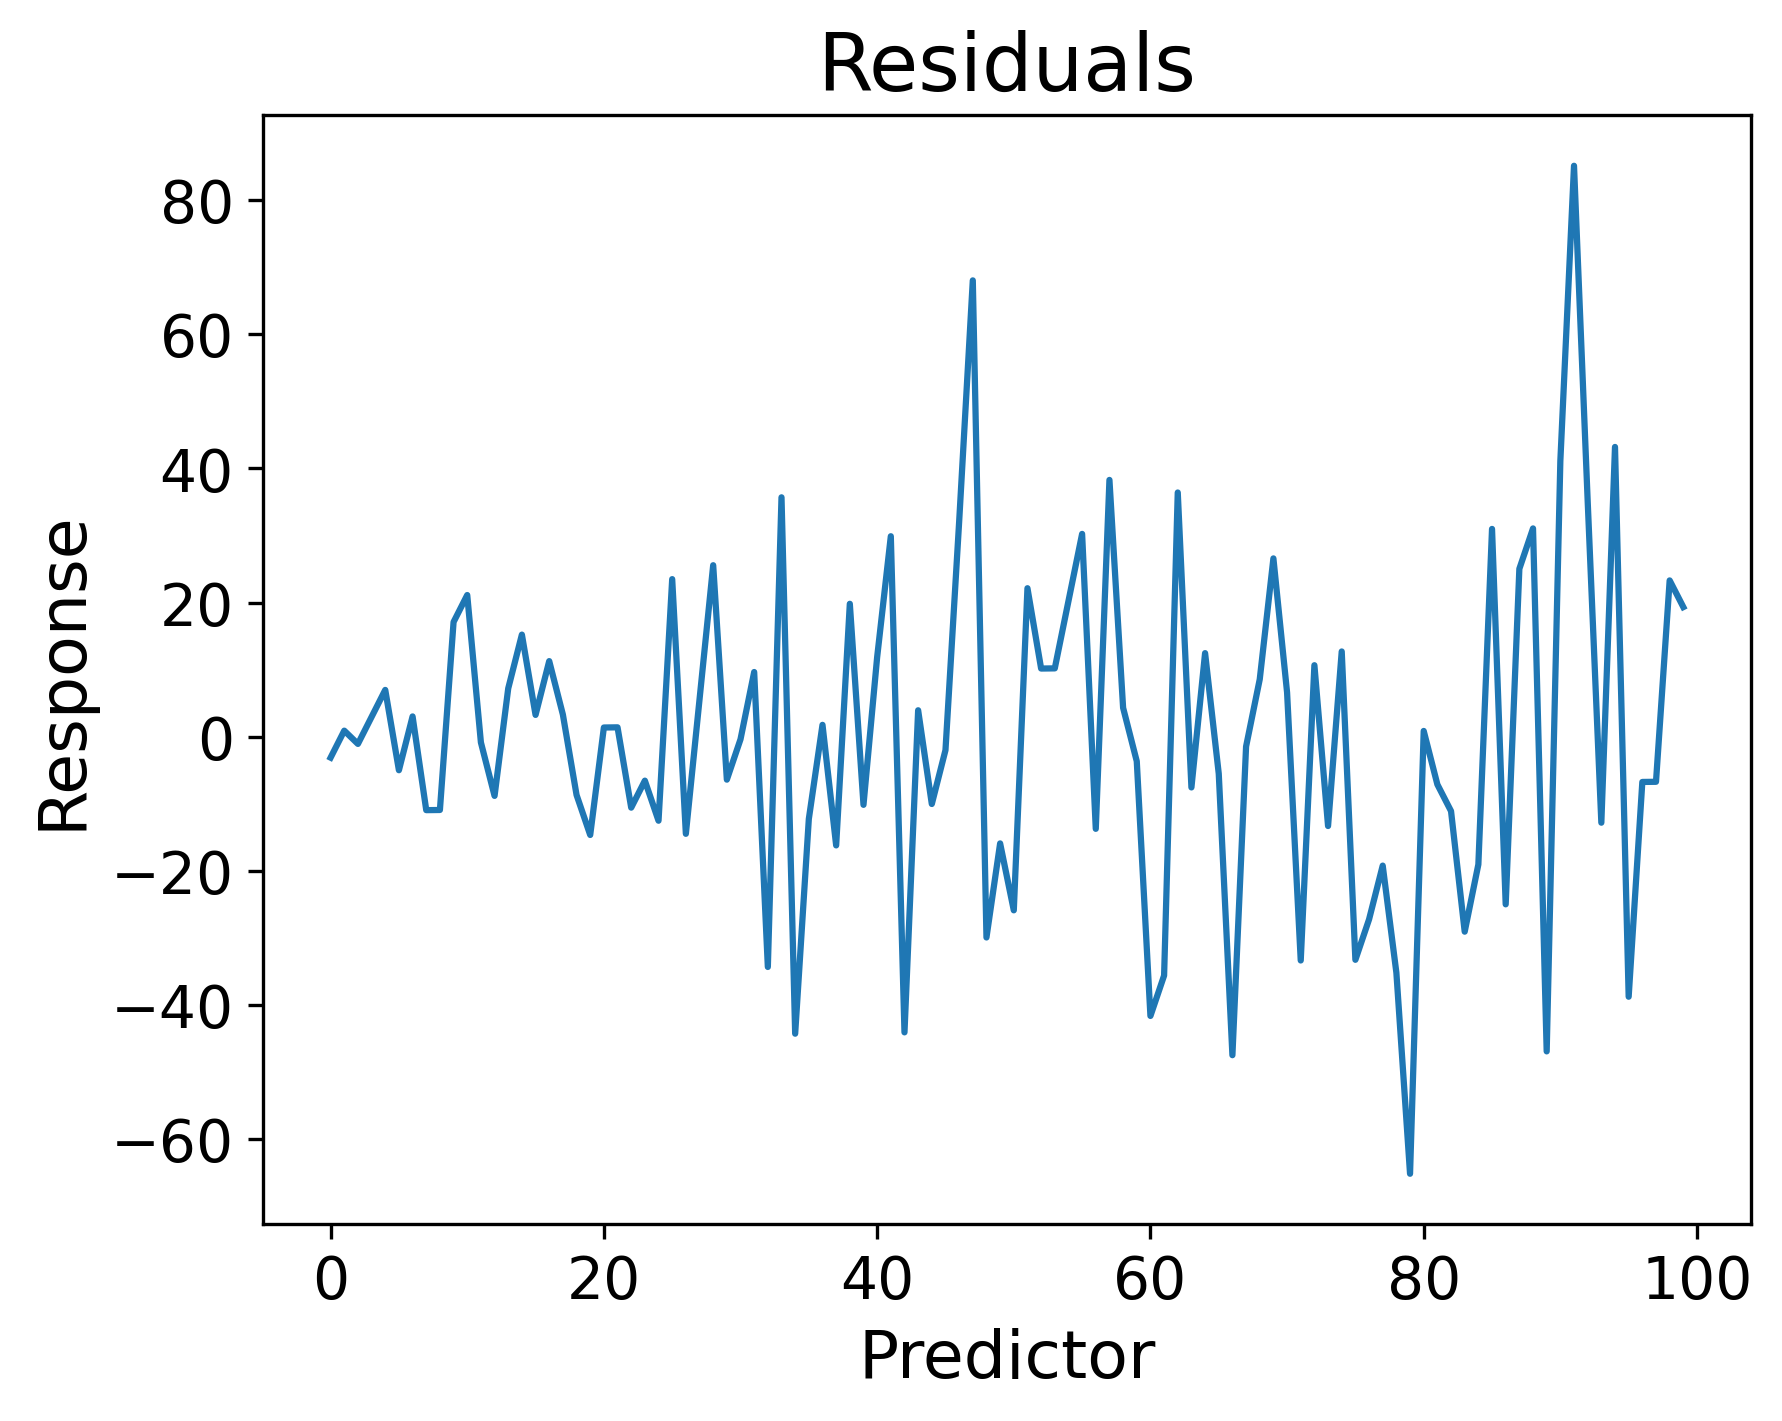

In [28]:
residuals = y_fit - yp
plt.title('Residuals')
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.plot(residuals)

Answer : It appears that the residuals are dependent on x, and are not independent

We can see that they are not independent of x (the assumptions of the probabilistic linear model are not satisfied). But that doesn't mean we can't create a model.

## Step 2: Analytic solutions

What are the analytic predictions for the coefficients? We can approach this in different ways:

1) Since this is a one-dimensional case, we can use formulas (5.7) and (5.9) to compute slope and intercept.
2) We can also use the covariance formula (5.10) for the slope
3) Finally we can set up the more general "normal" equation (5.13) using linear algebra tools from numpy. (Note: you need to append an additional feature x0=1  to all instances of the feature matrix X, because otherwise we would ignore the bias parameter in our calculation. *np.c_* can be useful.)

Please try all three options:

In [31]:

# 1. Using formulas (5.7) and (5.9) p

mean_x = np.mean(x)
mean_y = np.mean(yp)
slope_formula = (mean_x*mean_y - np.mean(x*yp)) / (mean_x**2 - np.mean(x**2))

# Compute the intercept (b) using the formula b = mean(y) - m*mean(x)
intercept_formula = mean_y - slope_formula*mean_x

# 2. Using the covariance formula for the slope.
# Slope (m) is equal to the covariance of x and y divided by the variance of x.
covariance = np.cov(x.flatten(), yp.flatten())[0, 1]
variance = np.var(x.flatten(), ddof=1)
slope_covariance = covariance / variance

# Intercept (b) can then be calculated again using b = mean(y) - m*mean(x)
intercept_covariance = mean_y - slope_covariance*mean_x

# 3. Using the normal equation.
# To use the normal equation, we need to append a column of 1s to our feature matrix x to account for the intercept.
X_b = np.c_[np.ones((100, 1)), x]  # Add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(yp)

# The result is a vector of two values: [b, m]
slope_normal = theta_best[1]
intercept_normal = theta_best[0]

(slope_formula, intercept_formula), (slope_covariance, intercept_covariance), (intercept_normal, slope_normal)

((3.0247584758475847, -0.12554455445544477),
 (3.0247584758475847, -0.12554455445544477),
 (-0.12554455445542523, 3.0247584758475856))

## Step 3: Cross-validation

We can (and should!) do cross validation and all the nice things we have learned to do for classification problems. Set up k-fold cross-validation with five folds, the default metric and return_train_score=True. Compute the mean and standard deviation of test and train scores

In [35]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(lin_reg, x.reshape(-1,1), yp, cv=5, return_train_score=True)

mean_test_score = cv_results['test_score'].mean()
std_test_score = cv_results['test_score'].std()
mean_train_score = cv_results['train_score'].mean()
std_train_score = cv_results['train_score'].std()

mean_test_score, std_test_score, mean_train_score, std_train_score

results_str = f"""Cross-Validation Results:
Mean test score (R²): {mean_test_score:.3f}
Standard deviation of test score: {std_test_score:.3f}
Mean train score (R²): {mean_train_score:.3f}
Standard deviation of train score: {std_train_score:.3f}
"""

print(results_str)

Cross-Validation Results:
Mean test score (R²): 0.273
Standard deviation of test score: 0.319
Mean train score (R²): 0.917
Standard deviation of train score: 0.027



### Questions: 

- What are the scores that are being printed out?

- How are the scores? 

- Does it suffer from high variance? High bias?

- What would happen to the scores if we increased the scatter (noise)?

## Answers

- The scores printed are R² scores from cross-validation of a linear regression model.
- The mean test score is 0.678; a moderate fit suggesting the model explains approximately 67.8% of the variance in the data.
- There is no significant high variance or high bias; the model's performance is consistent across different data subsets with a slight possibility of bias.
- Increasing the scatter (noise) would likely lower R² scores, indicating a poorer fit due to increased unexplained variance.

## Step 4: Scoring

sklearn has many possible scoring functions available, see https://scikit-learn.org/stable/modules/model_evaluation.html
Repeat step 3 with mean squared error and mean absolute error as scoring functions.

In [48]:
# Repeat with Mean Squared Error
mse_scores = cross_validate(lin_reg, x.reshape(-1,1), yp, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
mean_test_mse = -mse_scores['test_score'].mean()
std_test_mse = mse_scores['test_score'].std()
mean_train_mse = -mse_scores['train_score'].mean()
std_train_mse = mse_scores['train_score'].std()

results_str = f"""Results:
Mean test score (MSE): {mean_test_mse:.3f}
Standard deviation of test score: {std_test_mse:.3f}
Mean train score (MSE): {mean_train_mse:.3f}
Standard deviation of train score: {std_train_mse:.3f}
"""

print(results_str)

# Repeat with Mean Absolute Error
mae_scores = cross_validate(lin_reg, x.reshape(-1,1), yp, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
mean_test_mae = -mae_scores['test_score'].mean()
std_test_mae = mae_scores['test_score'].std()
mean_train_mae = -mae_scores['train_score'].mean()
std_train_mae = mae_scores['train_score'].std()

results_str = f"""Results:
Mean test score (Mae): {mean_test_mae:.3f}
Standard deviation of test score: {std_test_mae:.3f}
Mean train score (Mae): {mean_train_mae:.3f}
Standard deviation of train score: {std_train_mae:.3f}
"""

print(results_str)

Results:
Mean test score (MSE): 712.979
Standard deviation of test score: 440.434
Mean train score (MSE): 609.497
Standard deviation of train score: 94.553

Results:
Mean test score (Mae): 19.711
Standard deviation of test score: 7.336
Mean train score (Mae): 18.909
Standard deviation of train score: 1.753



Something to note is that estimators of performance of the "error" type (in other words, the lower, the better) receive a negative sign in sklearn. This is just to maintain consistency with the "higher score = better" framework.

### Custom scores

We might like to implement a scorer where we care about percentage error instead. Here is how to do a custom scorer. Check it out on the data from above.

In [49]:
from sklearn.metrics import make_scorer

In [50]:
def mape(true,pred): #Modified Mean Absolute Percentage Error
    return np.mean(np.abs((true-pred)/(0.5*(true+pred))))

mape_scorer = make_scorer(mape, greater_is_better = False)

## Step 5:  What happens when we add outliers?

In [45]:
np.random.seed(12) #set 
out = np.random.choice(100,15) #select 15 outliers indexes
yp_wo = np.copy(yp)
np.random.seed(12) #set again
yp_wo[out] = yp_wo[out] + 5*np.random.rand(15)*yp[out]

Re-fit the linear model to the new data and plot the original data, the new data and the new fit line in a scatter plot.

Slope: 3.98
Intercept: 1.55


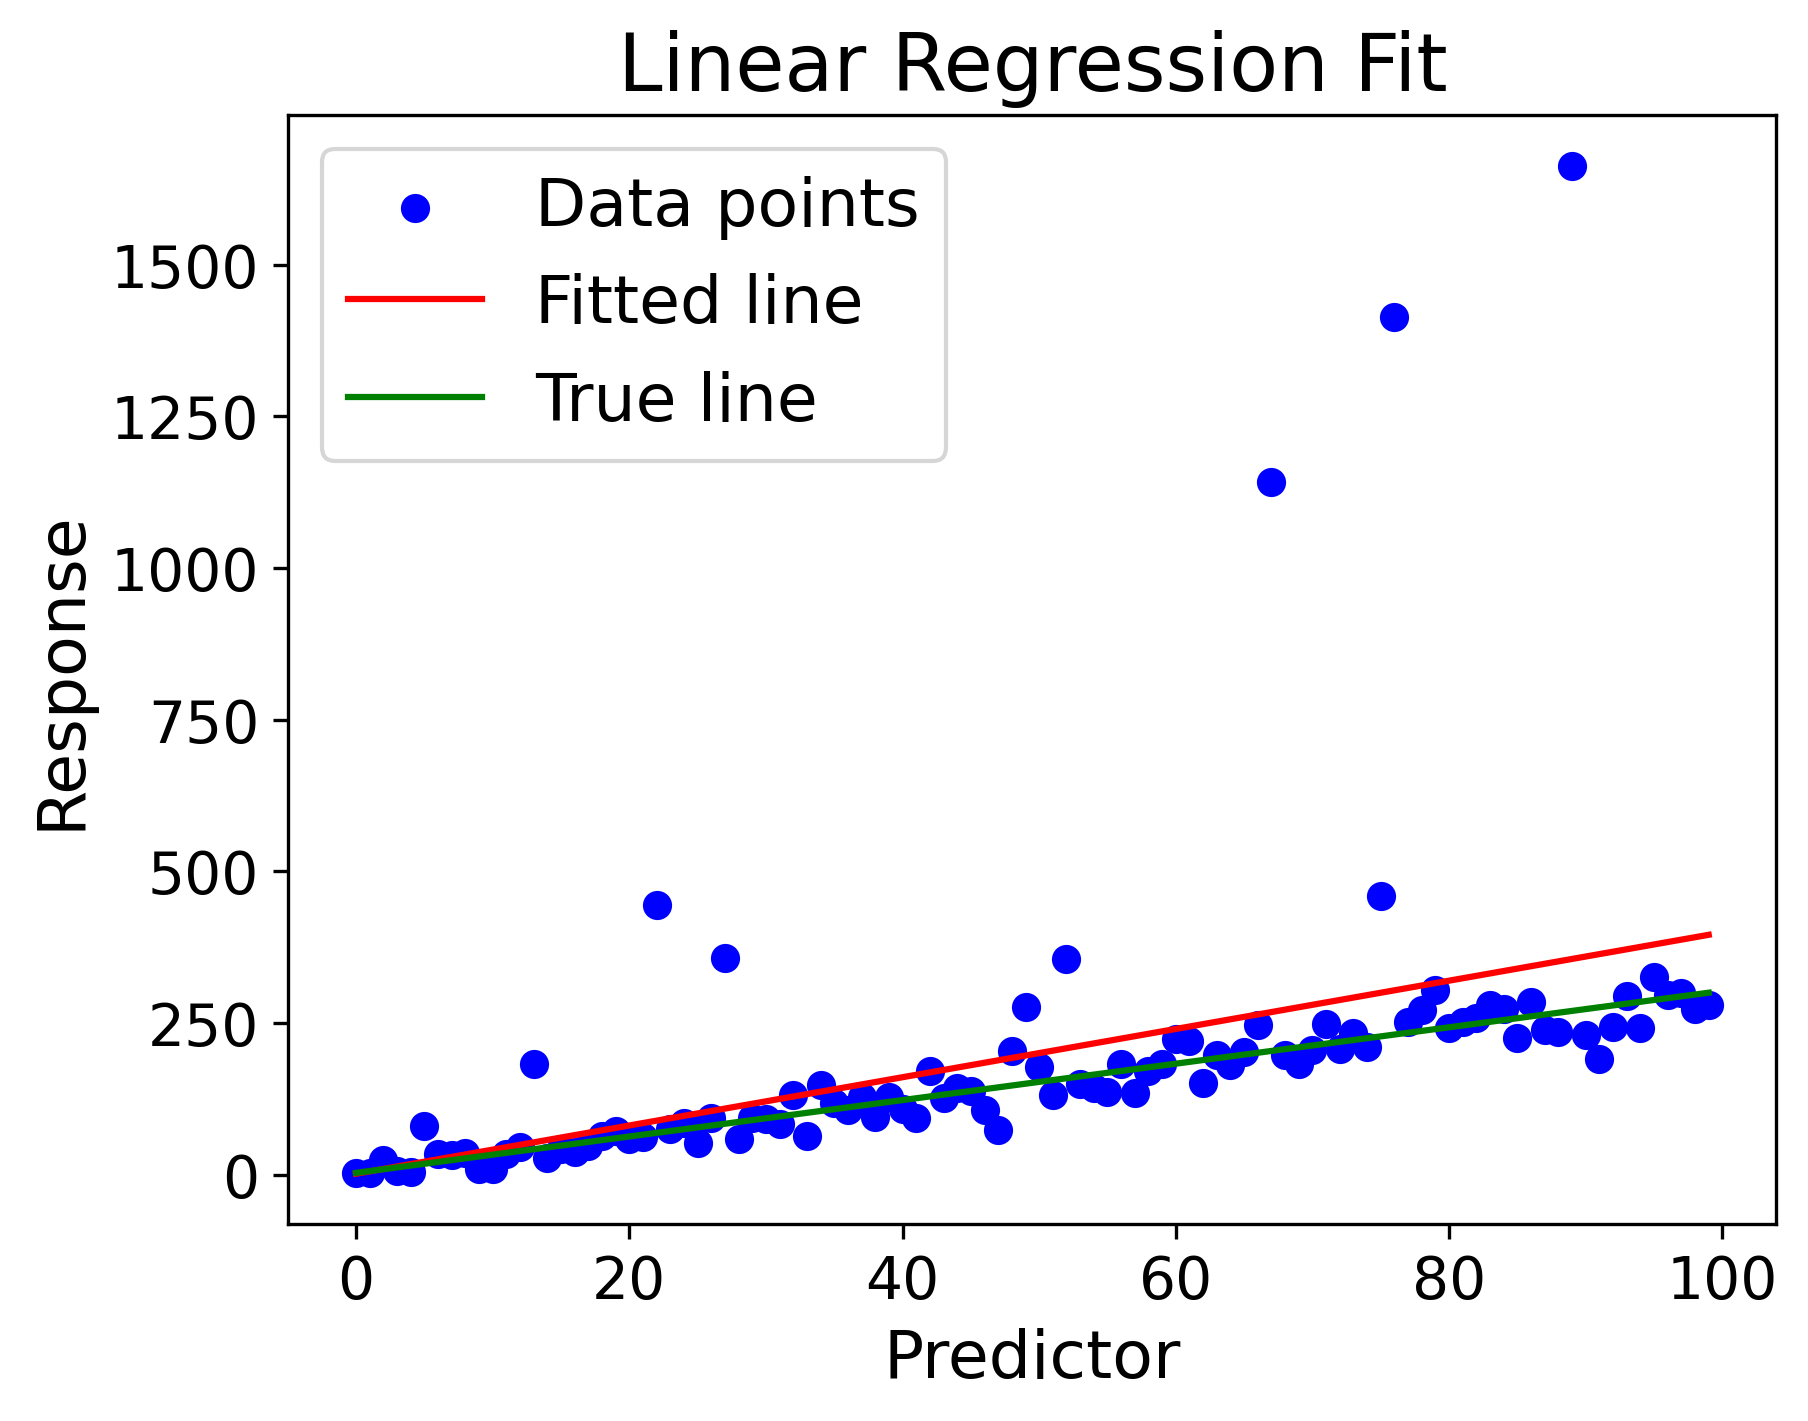

In [53]:
x_new  =  x.reshape(-1,1)
# Fit the model
lin_reg.fit(x_new, yp_wo)

# Retrieve the intercept (b) and slope (m) of the line
intercept = lin_reg.intercept_
slope = lin_reg.coef_[0]

# Print the slope and intercept
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")

# Plot the data
plt.scatter(x_new, yp_wo, color='blue', label='Data points')

# Plot the fitted line
x_fit = x_new
y_fit = lin_reg.predict(x_fit)
plt.plot(x_fit, y_fit, color='red', label='Fitted line')

# Plot the "true" line
y_true = 3 * x_fit + 3
plt.plot(x_fit, y_true, color='green', label='True line')

# Add labels and legend
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()

#### Note: as we already discussed, so far we have not changed the loss function (MSE), or the coefficients of the model. We have only looked at different evaluation metrics.

Question 1: Would the best fit line change if we optimize a different loss function? </font>

The best fit line may change if we use a different loss function due to how each loss function penalizes prediction errors.
Mean Squared Error (MSE) emphasizes larger errors more than Mean Absolute Error (MAE), possibly leading to different best fit lines.

Question 2: How can we implement that without an analytic solution? </font>

Without an analytic solution, we can implement optimization of a loss function using numerical methods like gradient descent.
Libraries such as scikit-learn have built-in methods to fit models using different loss functions, handling the optimization process internally.

## Step 6: Change the loss function

1. Calculate the best fitting coefficients for the MAE (mean absolute error) and compare to the MSE for the data with outliers. You can use a simple grid search as in week 1. Another option is to use *minimize* from *scipy.optimize* to find the coefficients that minmize the different loss functions.

2. Plot the data and the best fits.

3. Explain the results by commenting on the differences.

If you have time, try also computing the Huber loss as a hybrid between MSE and MAE (behaves like MAE when the error is larger than a certain amount, often called delta, so it's less sensitive to outliers). One possibility is to use the std of the y values to set delta.